# Adding secondary / discretionary locations to activity chains 

This notebook shows how to assign discretionary activities to locations based on a spac-time prism approach. Primary activities (home, work, education) are already assigned to zones. Secondary activities are assigned to zones that are feasible given reported travel times and modes. We use the open-source python library PAM for discretionary activity assignment

- See here for a walkthrough of the PAM functionality: https://github.com/arup-group/pam/blob/main/examples/17_advanced_discretionary_locations.ipynb
- For more info on the spacetime approach for secondary locaiton assignment, see https://www.tandfonline.com/doi/full/10.1080/23249935.2021.1982068

In [1]:
import os
from copy import deepcopy

import acbm

import numpy as np
import pandas as pd
import geopandas as gpd
import pam
from pam import read, write
from pam.activity import Activity, Leg, Plan
from pam.location import Location
from pam.planner.choice_location import DiscretionaryTripOD, DiscretionaryTrips
from pam.planner.od import ODFactory, ODMatrix
from pam.planner.utils_planner import get_trip_chains_either_anchor
from pam.plot.stats import plot_activity_times, plot_leg_times
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from prettytable import PrettyTable
from shapely.geometry import Point
from libpysal.weights import Queen


from acbm.preprocessing import nts_filter_by_year, add_location
from acbm.assigning.primary_select import select_facility
from acbm.logger_config import assigning_secondary_locations_logger as logger



pd.set_option('display.max_columns', None)


# Load in the data

In [2]:
activity_chains = pd.read_parquet(
    acbm.root_path / "data/interim/matching/spc_with_nts_trips.parquet"
)
activity_chains = activity_chains[activity_chains["TravDay"] == 3]  # Wednesday


In [3]:
activity_chains.head(20)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH
6,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053
7,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053
8,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570
9,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570
10,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,5.0,2.0,1.0,5.0,car,home,work,2.0,810.0,830.0,13.0,13.0,20.0,20.0,2.0,2.0,0.568328,1.000000
11,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,2.0,0.568328,1.000000
25,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 20

## Add OA21CD to the data

We will use it to select home locations using select_facility()

In [ ]:
where_clause = "MSOA21NM LIKE '%Leeds%'"

boundaries = gpd.read_file(
    acbm.root_path / "data/external/boundaries/oa_england.geojson", where=where_clause
)

# convert boundaries to 4326
boundaries = boundaries.to_crs(epsg=4326)


# --- Assign activity home locations to boundaries zoning system

# Convert location column in activity_chains to spatial column
centroid_layer = pd.read_csv(
    acbm.root_path / "data/external/centroids/Output_Areas_Dec_2011_PWC_2022.csv"
)
activity_chains = add_location(
    activity_chains, "EPSG:27700", "EPSG:4326", centroid_layer, "OA11CD", "OA11CD"
)

# Convert the DataFrame into a GeoDataFrame, and assign a coordinate reference system (CRS)
activity_chains = gpd.GeoDataFrame(activity_chains, geometry="location")
activity_chains.crs = "EPSG:4326"  # I assume this is the crs


# remove index_right column from activity_chains if it exists
if "index_right" in activity_chains.columns:
    activity_chains = activity_chains.drop(columns="index_right")


# Spatial join to identify which polygons each point is in
activity_chains = gpd.sjoin(
    activity_chains, boundaries[["OA21CD", "geometry"]], how="left", predicate="within"
)
activity_chains = activity_chains.drop("index_right", axis=1)

In [5]:
# remove location column
activity_chains = activity_chains.drop(columns="location")

## Primary locations

In [6]:
activity_chains_edu = pd.read_pickle(
    acbm.root_path / "data/interim/assigning/activity_chains_education.pkl"
)

activity_chains_work = pd.read_pickle(
    acbm.root_path / "data/interim/assigning/activity_chains_work.pkl"
)


In [7]:
# remove activity_id and activity_geom columns from activity_chains_edu and activity_chains_work
# TODO: remove them upsteam and create a script specifically for select_facility functionality
activity_chains_edu = activity_chains_edu.drop(
    columns=["activity_id", "activity_geom"]
)

activity_chains_work = activity_chains_work.drop(
    columns=["activity_id", "activity_geom"]
)

In [8]:
activity_chains_edu.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,location,OA21CD
0,201,89,2903217,E02002330,E00059031,"[199, 200, 201]",None,NaN,0,NaN,NaN,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,7,1,2.0,34166.520508,2,0,2,1,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",2,2021004708,education_school,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,3.0,3.0,1.0,2.0,1.0,8.0,car,home,education,3.0,520.0,525.0,1.0,1.0,5.0,5.0,2.0,E00059030,0.568328,1.000000,POINT (-1.39680 53.93384),E00059031
1,612,283,2909651,E02002330,E00059012,"[610, 611, 612, 613]",None,NaN,0,NaN,NaN,E02002330_0284,1.0,NaN,6.0,True,5.0,1,1,8,1,3.0,0.000000,1,0,2,1,2,0,1,0,0,1,E00059012,Urban city and town,C1,Urban,Urban City and Town,1,2,2.0,[2019000846.0],2,2019002010,education_school,2.019027e+09,2.019013e+09,2.019002e+09,2.019001e+09,2.019000e+09,3.0,3.0,1.0,2.0,1.0,7.0,car,home,education,3.0,NaN,NaN,2.5,2.5,12.0,12.0,2.0,E00059023,0.809313,1.008714,POINT (-1.38647 53.94082),E00059012
2,613,283,2905230,E02002330,E00059012,"[610, 611, 612, 613]",None,NaN,0,NaN,NaN,E02002330_0284,1.0,NaN,6.0,True,5.0,1,2,2,1,3.0,0.000000,1,0,2,1,2,0,1,0,0,1,E00059012,Urban city and town,C1,Urban,Urban City and Town,1,2,2.0,[2019000846.0],1,2019002011,education_kg,2.019027e+09,2.019013e+09,2.019002e+09,2.019001e+09,2.019000e+09,4.0,3.0,1.0,2.0,1.0,7.0,car,home,education,3.0,NaN,NaN,2.5,2.5,12.0,12.0,2.0,E00059023,0.809313,1.008714,POINT (-1.38647 53.94082),E00059012
3,4550,2107,2912299,E02002330,E00059038,"[4548, 4549, 4550]",None,NaN,0,NaN,NaN,E02002330_2108,1.0,NaN,6.0,True,2.0,2,1,5,1,2.0,0.000000,1,0,2,1,1,0,0,0,0,1,E00059038,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",2,2019003222,education_school,2.019043e+09,2.019021e+09,2.019003e+09,2.019001e+09,2.019000e+09,3.0,3.0,1.0,2.0,1.0,7.0,car,home,education,3.0,490.0,510.0,3.5,3.5,20.0,20.0,6.0,E00059036,1.179377,1.008714,POINT (-1.40113 53.92999),E00059038
4,5486,2499,2903909,E02002330,E00059022,"[5484, 5485, 5486]",None,NaN,0,NaN,NaN,E02002330_2500,1.0,NaN,6.0,True,1.0,2,2,15,1,1.0,4926.177246,1,0,2,1,1,0,1,0,1,2,E00059022,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2021000738.0, 2022002765.0, 2022003258.0]",3,2022007392,education_school,2.022083e+09,2.022044e+09,2.022007e+09,2.022003e+09,2.022001e+09,3.0,3.0,1.0,2.0,1.0,2.0,walk,home,education,3.0,485.0,505.0,1.0,1.0,20.0,20.0,3.0,E00059023,0.845366,1.000000,POINT (-1.39476 53.94100),E00059022
5,6310,2834,2901750,E02002330,E00059028,"[6308, 6309, 6310]",None,NaN,0,NaN,NaN,E02002330_2835,2.0,NaN,6.0,True,2.0,2,1,11,5,2.0,40131.613281,2,0,2,1,1,0,1,1,0,3,E00059028,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2021000738.0, 2022002765.0, 2022003258.0]",3,2022007392,education_school,2.022083e+09,2.022044e+09,2.022007e+09,2.022003e+09,2.022001e+09,3.0,3.0,1.0,2.0,1.0,2.0,walk,home,education,3.0,485.0,505.0,1.0,1.0,20.0,20.0,3.0,E00059030,0.845366,1.000000,POINT (-1.38813 53.93618),E00059028
6,9508,4118,2909584,E02002331,E00059025,"[9506, 9507, 9508]",None,NaN,0,NaN,NaN,E02002331_1196,1.0,NaN,6.0,True,2.0,2,1,9,1,6.0,0.000000,1,0,2,1,1,0,0,0,0,1,E00059025,Urban city and town,C1

In [9]:
# get all activity chains where dact is home
activity_chains_home = activity_chains[activity_chains["dact"] == "home"]
# get all activity chains where dact is not work or education
activity_chains_other = activity_chains[
    ~activity_chains["dact"].isin(["work", "education", "home"])
]


In [10]:
# Replace ozone and dzone with Na in activity_chains_other. They are incorrect and will be populated later
activity_chains_other.loc[:, ["ozone", "dzone"]] = np.nan
activity_chains_other.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,NaN,NaN,0.633716,1.115053,E00059031
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,NaN,NaN,0.639694,1.125570,E00059031
6,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004706,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,1.0,3.0,1.0,2.0,1.0,5.0,car,home,escort,5.0,765.0,840.0,1.0,1.0,75.0,45.0,NaN,NaN,0.646775,1.138030,E00059031
12,313,139,2911885,E02002330,E00059045,"[312, 313]",N,80.0,1,22676.896484,11.786329,E02002330_0140,1.0,NaN,6.0,True,1.0,1,1,64,3,2.0,22676.896484,1,1,2,0,0,0,0,1,0,3,E00059045,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",9,2021002995,education_university,2.021024e+09,2.021020e+09,2.021003e+09,2.021001e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,5.0,car,home,escort,5.0,400.0,401.0,0.3,0.3,1.0,1.0,NaN,NaN,0.961816,1.138030,E00059045
14,313,139,2911885,E02002330,E00059045,"[312, 313]",N,80.0,1,22676.896484,11.786329,E02002330_0140,1.0,NaN,6.0,True,1.0,1,1,64,3,2.0,22676.896484,1,1,2,0,0,0,0,1,0,3,E00059045,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",9,2021002995,education_university,2.021024e+09,2.021020e+09,2.021003e+09,2.021001e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,work,escort,5.0,1300.0,1322.0,13.0,13.0,22.0,22.0,NaN,NaN,0.961816,1.138030,E00059045
16,425,197,2901553,E02002330,E00059023,"[425, 426]",C,29.0,6,NaN,NaN,E02002330_0198,1.0,NaN,6.0,True,1.0,1,1,59,1,2.0,0.000000,1,1,1,0,1,0,0,0,0,1,E00059023,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001746.0, 2019001081.0, 2019001177.0, 201...",8,2022004472,education_university,2.022050e+09,2.022027e+09,2.022004e+09,2.022002e+09,2.022000e+09,1.0,3.0,1.0,2.0,1.0,5.0,car,home,other,7.0,540.0,554.0,2.7,2.7,14.0,14.0,NaN,NaN,1.356007,1.003426,E00059023
18,425,197,2901553,E02002330,E00059023,"[425, 426]",C,29.0,6,NaN,NaN,E02002330_0198,1.0,NaN,6.0,True,1.0,1,1,59,1,2.0,0.000000,1,1,1,0,1,0,0,0,0,1,E00059023,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001746.0, 2019001081.0, 2

In [11]:
(activity_chains.shape[0], 
 activity_chains_edu.shape[0], 
 activity_chains_work.shape[0], 
 activity_chains_home.shape[0], 
 activity_chains_other.shape[0])

(15811, 411, 1806, 6849, 6745)

In [12]:
activity_chains["dact"].value_counts()

dact
home         6849
other        2621
work         1806
escort       1762
shop         1281
visit         896
education     411
medical       185
Name: count, dtype: int64

In [13]:
# replace dzone column with OA21CD
activity_chains_home["dzone"] = activity_chains_home["OA21CD"]
activity_chains_home.head(10)

/tmp/ipykernel_55631/4036211998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activity_chains_home["dzone"] = activity_chains_home["OA21CD"]


,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,E00059031,0.633716,1.115053,E00059031
3,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,E00059031,0.639694,1.125570,E00059031
5,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,E00059031,0.568328,1.000000,E00059031
7,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004706,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,1.0,3.0,2.0,2.0,1.0,5.0,car,escort,home,5.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,E00059031,0.646775,1.138030,E00059031
9,201,89,2903217,E02002330,E00059031,"[199, 200, 201]",None,NaN,0,NaN,NaN,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,7,1,2.0,34166.520508,2,0,2,1,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",2,2021004708,education_school,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,3.0,3.0,2.0,2.0,1.0,7.0,car,medical,home,6.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,E00059031,0.646775,1.138030,E00059031
11,312,139,2911320,E02002330,E00059045,"[312, 313]",Q,86.0,6,NaN,NaN,E02002330_0140,1.0,NaN,6.0,True,1.0,1,2,64,1,2.0,22676.896484,1,1,2,0,0,0,0,1,0,3,E00059045,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",9,2021002994,education_university,2.021024e+09,2.021020e+09,2.021003e+09,2.021001e+09,2.021000e+09,1.0,3.0,2.0,2.0,1.0,7.0,car,work,home,2.0,1322.0,1323.0,0.3,0.3,1.0,1.0,8.0,E00059045,0.845159,1.000000,E00059045
15,313,139,2911885,E02002330,E00059045,"[312, 313]",N,80.0,1,22676.896484,11.786329,E02002330_0140,1.0,NaN,6.0,True,1.0,1,1,64,3,2.0,22676.896484,1,1,2,0,0,0,0,1,0,3,E00059045,Urban city and town,C1,Urban,Urban City a

# Combine all dataframes

In [14]:
# merge the three dataframes
activity_chains_all = pd.concat([activity_chains_edu, 
                                 activity_chains_work, 
                                 activity_chains_home,
                                 activity_chains_other])
# sort by houshold_id, individual_id, and sequence
activity_chains_all = activity_chains_all.sort_values(by=["household", "id", "seq"])
activity_chains_all.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,location,OA21CD
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,NaN,NaN,0.633716,1.115053,None,E00059031
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,E00059031,0.633716,1.115053,None,E00059031
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,NaN,NaN,0.639694,1.125570,None,E00059031
3,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,E00059031,0.639694,1.125570,None,E00059031
10,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,5.0,2.0,1.0,5.0,car,home,work,2.0,810.0,830.0,13.0,13.0,20.0,20.0,2.0,E00058564,0.568328,1.000000,None,NaN
5,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,E00059031,0.568328,1.000000,None,E00059031
6,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0

## Add hzone column

PAM needs this column and it is also useful for us


In [15]:
activity_chains_all["hzone"] = activity_chains_all["OA21CD"]

In [16]:
# TODO find out why some hzone values are NaN

# Fill NaN values in the hzone column with the first non-NaN value within the same group
activity_chains_all['hzone'] = activity_chains_all.groupby('id')['hzone'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# Verify the result
activity_chains_all.head(10)

/tmp/ipykernel_55631/2243285481.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  activity_chains_all['hzone'] = activity_chains_all.groupby('id')['hzone'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/tmp/ipykernel_55631/2243285481.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  activity_chains_all['hzone'] = activity_chains_all.groupby('id')['hzone'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,location,OA21CD,hzone
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,NaN,NaN,0.633716,1.115053,None,E00059031,E00059031
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,E00059031,0.633716,1.115053,None,E00059031,E00059031
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,NaN,NaN,0.639694,1.125570,None,E00059031,E00059031
3,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,E00059031,0.639694,1.125570,None,E00059031,E00059031
10,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,5.0,2.0,1.0,5.0,car,home,work,2.0,810.0,830.0,13.0,13.0,20.0,20.0,2.0,E00058564,0.568328,1.000000,None,NaN,E00059031
5,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,E00059031,0.568328,1.000000,None,E00059031,E00059031
6,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E020023

## Remove all people who don't start their day at home

They will raise an error in PAM

In [17]:
# group by id column, and remove all groups where oact is not home in the first row
activity_chains_all = activity_chains_all.sort_values(by=["household", "id", "seq"])

print(f'PRE-FILTERING: Number of activities: {activity_chains_all.shape[0]}, number of individuals: {activity_chains_all["id"].nunique()}')
total_activities = activity_chains_all.shape[0]

activity_chains_all = activity_chains_all.groupby("id").filter(lambda x: x.iloc[0]["oact"] == "home")

print(f'POST-FILTERING: Number of activities: {activity_chains_all.shape[0]}, number of individuals: {activity_chains_all["id"].nunique()}')

removed_activities = total_activities - activity_chains_all.shape[0]
percentage_removed = (removed_activities / total_activities) * 100
print(f'Removed {removed_activities} activities, which is {percentage_removed:.2f}% of the total activities')

PRE-FILTERING: Number of activities: 15811, number of individuals: 5630
POST-FILTERING: Number of activities: 15164, number of individuals: 5357
Removed 647 activities, which is 4.09% of the total activities


## Check modes

We can only use modes that we have travel times for

In [18]:
activity_chains_all["mode"].value_counts()

mode
car           11515
pt             1674
walk           1588
bike            333
motorcycle       54
Name: count, dtype: int64

In [19]:
# replace motorcyle with car
activity_chains_all["mode"] = activity_chains_all["mode"].replace("motorcycle", "car")

## Populate ozone column for primary activities

Our dfs have populated the `dzone` column for rows where `dact` matches: [home, work, education]. 
For each person, we look at rows where the `ozone` is one of [home, work, education], and populate the `ozone` column for the primary activity with the same value.

In [20]:
import pandas as pd
import numpy as np
from copy import deepcopy

def set_home_ozone(
        data, 
        oact_col, 
        ozone_col, 
        hzone_col):
    """
    Ensure that all rows where 'oact' is 'home' have 'ozone' set to 'hzone'.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame.
    oact_col : str
        The column name for the activity data.
    ozone_col : str
        The column name for the ozone data to be filled.
    hzone_col : str
        The column name for the home zone data.
    """
    home_rows = data[oact_col] == 'home'
    data.loc[home_rows, ozone_col] = data.loc[home_rows, hzone_col]

def shift_and_fill_column(
        data, 
        group_col, 
        source_col, 
        target_col, 
        initial_value_col=None, 
        oact_col=None, 
        hzone_col=None):
    """
    Fill the 'target_col' column by shifting the 'source_col' column within each group defined by 'group_col'.
    Optionally set the first row of 'target_col' in each group from another column.
    Ensure that all rows where 'oact' is 'home' have 'ozone' set to 'hzone'.

    Use case: Fill the 'ozone' column by shifting the 'dzone' column within each group defined by 'id_col'.
    Optionally set the first row of 'ozone' in each group from another column.

    Input: id | seq | oact      | dact     | ozone | dzone | hzone |
            1 |   1 | home      | work     | NaN   |     A |     X |
            1 |   2 | work      | shopping | NaN   |   NaN |     X |
            1 |   3 | shopping  | home     |  NaN  |   NaN |     X |

    Output:  id | seq | oact    | dact     | ozone | dzone | hzone |
              1 |   1 | home    | work     | X     |     A |     X |
              1 |   2 | work    | shopping | A     |   NaN |     X |
              1 |   3 | shopping| home     | C     |   X   |     X |


    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame.
    group_col : str
        The column name to group by.
    source_col : str
        The column name for the source data to be shifted.
    target_col : str
        The column name for the target data to be filled.
    initial_value_col : str, optional
        The column name to take the first row value from. Default is None.
    oact_col : str, optional
        The column name for the activity data. Default is None.
    hzone_col : str, optional
        The column name for the home zone data. Default is None.

    Returns
    -------
    pandas DataFrame
        The DataFrame with the 'target_col' column filled.
    """
    # Create a deep copy of the DataFrame to avoid modifying the original
    data_copy = deepcopy(data)

    # Set all values in the target column to NaN
    data_copy[target_col] = np.nan

    # Group by 'group_col' and apply the shift operation within each group
    data_copy[target_col] = data_copy.groupby(group_col)[source_col].shift(1)

    # Optionally set the first row of 'target_col' in each group from another column
    if initial_value_col is not None:
        first_rows = data_copy.groupby(group_col).head(1).index
        data_copy.loc[first_rows, target_col] = data_copy.loc[first_rows, initial_value_col]

    # Ensure that all rows where 'oact' is 'home' have 'ozone' set to 'hzone'
    if oact_col is not None and hzone_col is not None:
        set_home_ozone(data_copy, oact_col, target_col, hzone_col)

    return data_copy

In [21]:
# Apply the function
activity_chains_all = shift_and_fill_column(
    data = activity_chains_all, 
    group_col = 'id', 
    source_col ='dzone', 
    target_col = 'ozone', 
    initial_value_col='hzone',
    oact_col='oact',
    hzone_col='hzone')

activity_chains_all.head(5)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,location,OA21CD,hzone
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,E00059031,NaN,0.633716,1.115053,None,E00059031,E00059031
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,E00059031,E00059031,0.633716,1.115053,None,E00059031,E00059031
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,E00059031,NaN,0.639694,1.125570,None,E00059031,E00059031
3,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,E00059031,E00059031,0.639694,1.125570,None,E00059031,E00059031
10,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,5.0,2.0,1.0,5.0,car,home,work,2.0,810.0,830.0,13.0,13.0,20.0,20.0,E00059031,E00058564,0.568328,1.000000,None,NaN,E00059031


Some people are still problematic. Remove them

In [45]:
# Create a boolean mask for groups where there is at least one row with hzone = NA
mask = activity_chains_all.groupby('id')['hzone'].transform(lambda x: x.isna().any())

print(f'Number of individuals to be removed: {activity_chains_all[mask]["id"].nunique()}')
print(f'Number of activities to be removed: {mask.sum()}')

# Use the mask to filter out the rows from the original DataFrame
activity_chains_all = activity_chains_all[~mask]

Number of individuals to be removed: 26
Number of activities to be removed: 27


,id,household,nts_ind_id,nts_hh_id,age_years,oact,dact,TripTotalTime,TripDisIncSW,seq,mode,tst,tet,ozone,dzone,hzone
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,other,45.0,6.0,1.0,walk,600.0,645.0,E00059031,NaN,E00059031
1,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,other,home,45.0,6.0,2.0,walk,645.0,690.0,E00059031,E00059031,E00059031
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,shop,10.0,1.0,3.0,car,720.0,730.0,E00059031,NaN,E00059031
3,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,shop,home,10.0,1.0,4.0,car,765.0,775.0,E00059031,E00059031,E00059031
10,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,work,20.0,13.0,5.0,car,810.0,830.0,E00059031,E00058564,E00059031


In [46]:
activity_chains_all = activity_chains_all[["id", "household", "nts_ind_id", "nts_hh_id", "age_years", 
                                           "oact", "dact", "TripTotalTime", "TripDisIncSW", "seq", "mode", "tst", "tet", 
                                           "ozone", "dzone", "hzone"]]

activity_chains_all.head(10)

,id,household,nts_ind_id,nts_hh_id,age_years,oact,dact,TripTotalTime,TripDisIncSW,seq,mode,tst,tet,ozone,dzone,hzone
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,other,45.0,6.0,1.0,walk,600.0,645.0,E00059031,NaN,E00059031
1,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,other,home,45.0,6.0,2.0,walk,645.0,690.0,E00059031,E00059031,E00059031
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,shop,10.0,1.0,3.0,car,720.0,730.0,E00059031,NaN,E00059031
3,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,shop,home,10.0,1.0,4.0,car,765.0,775.0,E00059031,E00059031,E00059031
10,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,work,20.0,13.0,5.0,car,810.0,830.0,E00059031,E00058564,E00059031
5,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,work,home,30.0,13.0,6.0,car,1230.0,1260.0,E00059031,E00059031,E00059031
6,200,89,2021004706,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",38,home,escort,75.0,1.0,1.0,car,765.0,840.0,E00059031,NaN,E00059031
7,200,89,2021004706,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",38,escort,home,20.0,1.0,2.0,car,930.0,950.0,E00059031,E00059031,E00059031
0,201,89,2021004708,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,home,education,5.0,1.0,1.0,car,520.0,525.0,E00059031,E00059030,E00059031
9,201,89,2021004708,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,medical,home,20.0,1.0,2.0,car,930.0,950.0,E00059031,E00059031,E00059031


# Prepare data for PAM 

## Individuals

In [48]:
individuals = activity_chains_all[['id', 'household', 'age_years']].drop_duplicates(subset=['id'])

# rename columns
individuals = individuals.rename(columns={"id": "pid", "household": "hid"})
individuals.head(10)

,pid,hid,age_years
0,199,89,39
6,200,89,38
0,201,89,7
66,312,139,64
12,313,139,64
16,425,197,59
28,611,283,64
1,612,283,8
2,613,283,2
37,743,342,37


## Households

## Trips 

In [49]:
trips = activity_chains_all[['id', 'household', 'seq', 'hzone', 'ozone', 'dzone', 'dact', 'mode', 'tst', 'tet']]

# rename columns
trips = trips.rename(columns={"id": "pid", "household": "hid", "dact": "purp"})

# Drop NA values in tst and tet columns and convert to int
trips = trips.dropna(subset=['tst', 'tet'])
trips['tst'] = trips['tst'].astype(int)
trips['tet'] = trips['tet'].astype(int)

trips.head(10)

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet
0,199,89,1.0,E00059031,E00059031,NaN,other,walk,600,645
1,199,89,2.0,E00059031,E00059031,E00059031,home,walk,645,690
2,199,89,3.0,E00059031,E00059031,NaN,shop,car,720,730
3,199,89,4.0,E00059031,E00059031,E00059031,home,car,765,775
10,199,89,5.0,E00059031,E00059031,E00058564,work,car,810,830
5,199,89,6.0,E00059031,E00059031,E00059031,home,car,1230,1260
6,200,89,1.0,E00059031,E00059031,NaN,escort,car,765,840
7,200,89,2.0,E00059031,E00059031,E00059031,home,car,930,950
0,201,89,1.0,E00059031,E00059031,E00059030,education,car,520,525
9,201,89,2.0,E00059031,E00059031,E00059031,home,car,930,950


In [50]:
# replace Nan values in ozone and dzone with "na"
trips['ozone'] = trips['ozone'].apply(lambda x: None if pd.isna(x) else x)
trips['dzone'] = trips['dzone'].apply(lambda x: None if pd.isna(x) else x)
trips['hzone'] = trips['hzone'].apply(lambda x: None if pd.isna(x) else x)
trips.head(10)

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet
0,199,89,1.0,E00059031,E00059031,None,other,walk,600,645
1,199,89,2.0,E00059031,E00059031,E00059031,home,walk,645,690
2,199,89,3.0,E00059031,E00059031,None,shop,car,720,730
3,199,89,4.0,E00059031,E00059031,E00059031,home,car,765,775
10,199,89,5.0,E00059031,E00059031,E00058564,work,car,810,830
5,199,89,6.0,E00059031,E00059031,E00059031,home,car,1230,1260
6,200,89,1.0,E00059031,E00059031,None,escort,car,765,840
7,200,89,2.0,E00059031,E00059031,E00059031,home,car,930,950
0,201,89,1.0,E00059031,E00059031,E00059030,education,car,520,525
9,201,89,2.0,E00059031,E00059031,E00059031,home,car,930,950


## Read population 

tour_based = False assumes all trips start from home - this is ok for matsim 
see here https://arup-group.github.io/pam/latest/reference/pam/read/diary/#pam.read.diary.load_travel_diary


In [ ]:
population = pam.read.load_travel_diary(
    trips = trips,
    persons_attributes = individuals,
    tour_based = False
    #hhs_attributes = None,
    )



In [ ]:
plot_activity_times(population)

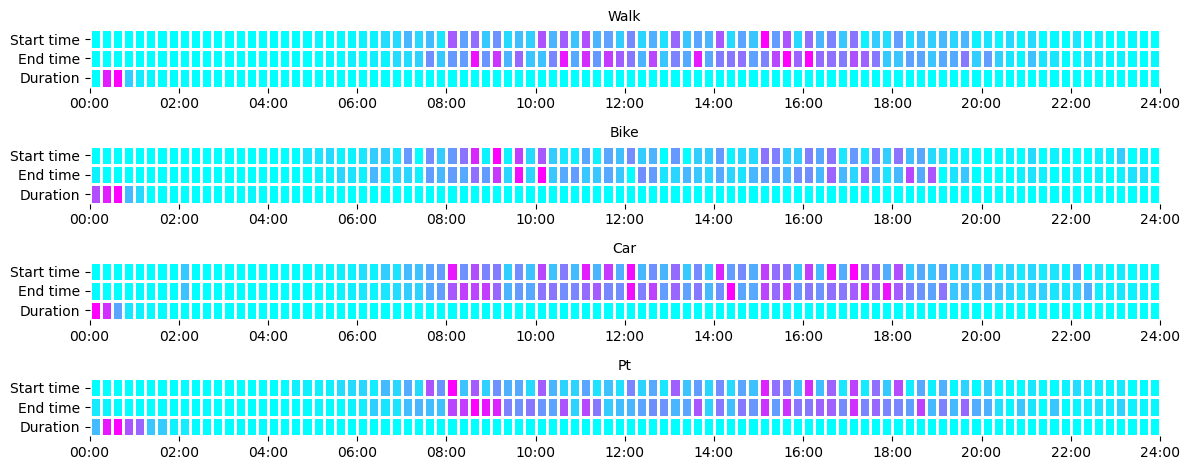

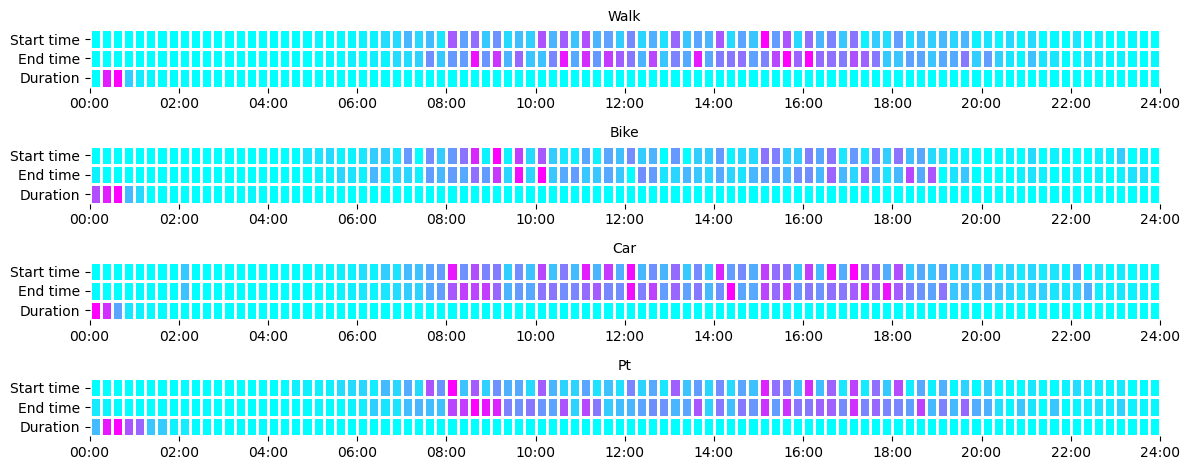

In [53]:
plot_leg_times(population)

## Matrices for OD Factory 

The PAM OD factory function needs the following matrices

- travel times (by mode)
- travel distances (this appears optional so I will ignore it for now)
- od_probs: probability of travelling between each pair of zones (by mode)

### Get data: Travel time matrices

In [ ]:
travel_times = pd.read_parquet(
    acbm.root_path / "data/external/travel_times/oa/travel_time_matrix_acbm.parquet"
)

travel_times

#### Edit modes

We have travel times for PT by time of day. In discretionary trips, PAM needs the mode column to match the mode labels in ODFactory (see https://github.com/arup-group/pam/blob/main/examples/17_advanced_discretionary_locations.ipynb). We have two options

1. TODO: Preferred: Before reading the population into PAM, edit the mode column of the trips table to replace pt with pt_wkday_morning, pt_wkday_evening etc depending on day and time of trip. I dont know if this will work downstream
2. Simplify our travel time data. Use the same travel time regardless of time of day, and label as pt (to match with mode column)

I will do 2 for now

In [ ]:
# keep only the rows that match specific "combination" values

modes_to_use = ['car', 'walk', 'cycle', 'pt_wkday_morning']

# Filter the DataFrame
travel_times = travel_times[travel_times['combination'].isin(modes_to_use)]

# Rename specific values in "combination" column
travel_times['combination'] = travel_times['combination'].replace({
    'cycle': 'bike',
    'pt_wkday_morning': 'pt'
})

#### Add OA21CD

In [ ]:
# convert from_id and to_id to int to match the boundaries data type
travel_times = travel_times.astype({"from_id": int, "to_id": int})

# merge travel_times with boundaries
travel_times = travel_times.merge(
    boundaries[["OBJECTID", "OA21CD"]],
    left_on="from_id",
    right_on="OBJECTID",
    how="left",
)
travel_times = travel_times.drop(columns="OBJECTID")

travel_times = travel_times.merge(
    boundaries[["OBJECTID", "OA21CD"]],
    left_on="to_id",
    right_on="OBJECTID",
    how="left",
    suffixes=("_from", "_to"),
)
travel_times = travel_times.drop(columns="OBJECTID")

travel_times.head(10)

### Get data: OD probabilities

We use the activities_per_zone data to calculate the OD probabilities

In [ ]:
activities_per_zone = pd.read_parquet(
    acbm.root_path / "data/interim/assigning/activities_per_zone.parquet"
)

activities_per_zone.head(5)

In [ ]:
# keep only rows that don't match primary activities
activities_per_zone = activities_per_zone[activities_per_zone["activity"].isin(["shop", "other", "medical", "visit"])]

# group by zone and get sum of counts and floor_area
activities_per_zone = activities_per_zone.groupby("OA21CD").agg({"counts": "sum", "floor_area": "sum"}).reset_index()
activities_per_zone.head(5)

In [ ]:
# Merge to get floor_area for origin
merged_df = travel_times.merge(activities_per_zone, left_on='OA21CD_to', right_on='OA21CD')

# Calculate the visit_probability: it is a funciton of floor_area and travel time
merged_df['visit_prob'] = np.where(merged_df['travel_time_p50'] != 0, 
                              round(merged_df['floor_area'] / np.sqrt(merged_df['travel_time_p50'])), 
                              round(merged_df['floor_area'])
                              )

merged_df

### Create matrices

In [ ]:
def create_od_matrices(
        df: pd.DataFrame, 
        mode_column: str, 
        value_column: str,
        zone_labels: tuple,
        fill_value: int,
        zone_from: str = 'OA21CD_from',
        zone_to: str = 'OA21CD_to',
        ) -> dict:
    
    """
    Create OD matrices for each mode in the DataFrame. This function is uused to create matrices for 
    - travel times
    - od_probs
    to be used in discretionary activity selection

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data
    mode_column : str
        Column name containing the mode of transport
    value_column : str
        Column name containing the value to be used in the OD matrix
    fill_value : int
        Value to use when a value for a specific od pair is not available

    Returns
    -------
    dict
        A dictionary containing OD matrices for each mode.
        Key: str
            Mode of transport
        Value: np.array
            OD matrix

    """
    
    # Initialize dictionaries to hold OD matrices for each combination type
    modes = df[mode_column].unique()
    od_matrices = {mode: np.full((len(zone_labels), len(zone_labels)), fill_value) for mode in modes}
    
    # Create a mapping from zone labels to indices
    zone_index = {label: idx for idx, label in enumerate(zone_labels)}
    
    # Vectorized operation to populate OD matrices
    from_indices = df[zone_from].map(zone_index)
    to_indices = df[zone_to].map(zone_index)
    
    for mode in modes:
        print(f"Starting mode: {mode}")
        mask = df[mode_column] == mode
        values = df[mask][value_column].fillna(fill_value)  # Fill missing values 
        od_matrices[mode][from_indices[mask], to_indices[mask]] = values
        print(f"Finished mode: {mode}")
    
    return od_matrices



In [ ]:
# Extract unique zone labels. 
# TODO: get these from boundary/zone layer instead
zone_labels = pd.unique(travel_times[['OA21CD_from', 'OA21CD_to']].values.ravel('K'))
zone_labels = tuple(zone_labels)
print(zone_labels[:5])

#### Create travel time matrices

In [ ]:
matrix_travel_times = create_od_matrices(
    df = merged_df, 
    mode_column = 'combination', 
    value_column = 'travel_time_p50', 
    zone_labels = zone_labels,
    fill_value = 300,  # replace missing travel times with 6 hours (they are unreachable)
    zone_from='OA21CD_from', 
    zone_to='OA21CD_to'
    )

In [ ]:
matrix_travel_times["car"][100:110, 100:110]

#### Create od probs matrices

In [ ]:
matrix_od_probs = create_od_matrices(
    df = merged_df, 
    mode_column = 'combination', 
    value_column = 'visit_prob', 
    zone_labels = zone_labels,
    # replace missing probabilities with 1. There are no activities so shouldn't be visited
    # 1 used instead of 0 to avoid (ValueError: Total of weights must be finite) in weighted sampling 
    # (https://github.com/arup-group/pam/blob/c8bff760fbf92f93f95ff90e4e2af7bbe107c7e3/src/pam/planner/utils_planner.py#L17)
    fill_value = 1,  
    zone_from='OA21CD_from', 
    zone_to='OA21CD_to'
    )

In [ ]:
#matrix_od_probs["walk"][100:110, 100:110]
matrix_od_probs["walk"][0:10, 0:10]


#### Create ODMatrix objects

In [ ]:
mode_types = travel_times['combination'].unique()

In [ ]:
matrices_pam_travel_time = [
    ODMatrix("time", mode, zone_labels, zone_labels, matrix_travel_times[mode])
    for mode in mode_types
]

In [ ]:
matrices_pam_travel_time[1]

In [ ]:
matrices_pam_od_probs = [
    ODMatrix("od_probs", mode, zone_labels, zone_labels, matrix_od_probs[mode])
    for mode in mode_types
]

#### Create ODFactory object 

In [ ]:
# combine ODMatrix objects
matrices_pam_all = matrices_pam_travel_time + matrices_pam_od_probs
matrices_pam_all

In [ ]:
#create ODFactory
od = ODFactory.from_matrices(matrices = matrices_pam_all)


In [ ]:
od

### Discretionary activities

Test the implementation of discretionary activities

In [ ]:
def print_activity_locs(plan):
    summary = PrettyTable(["seq", "purpose", "location"])
    for seq, act in enumerate(plan.activities):
        summary.add_row([seq, act.act, act.location.area])
    print(summary)

In [ ]:
import random

plans_iterator = population.plans()
all_plans = list(plans_iterator)


random_plan = random.choice(all_plans)
print_activity_locs(random_plan)

In [ ]:
random_plan_copy = deepcopy(random_plan)
planner = DiscretionaryTrips(plan=random_plan_copy, od=od)
planner.update_plan()

print_activity_locs(random_plan_copy)

### Apply logic to entire population

In [ ]:
i = 0
people_list = list(population.people())
for plan in population.plans():
    try:
        planner = DiscretionaryTrips(plan=plan, od=od)
        planner.update_plan()
        print(f"Updated plan for person id {people_list[i][1]}")
    except Exception as e:
        # a pam population.people() object has hid, pid, <plan>. We want pid
        print(f"An error occurred with person id {people_list[i][1]}: {e}")
    i += 1



In [ ]:
def update_population_plans(population: pam.core.Population, 
                            od: ODFactory
                            ) -> None:
    """
    Update the plans in a population object using the DiscretionaryTrips planner

    """
    i = 0
    people_list = list(population.people())
    for plan in population.plans():
        try:
            planner = DiscretionaryTrips(plan=plan, od=od)
            planner.update_plan()
            logger.info(f"Updated plan for person id {people_list[i][0]}")
        except Exception as e:
            logger.error(f"An error occurred with person id {people_list[i][0]}: {e}")
        i += 1

update_population_plans(population, od)

## Save

In [ ]:
write.to_csv(population, dir=(
    acbm.root_path / "data/processed/activities_pam"
))

# Read activities back and assign point locations

In [ ]:
activities_pam = pd.read_csv(
    acbm.root_path / "data/processed/activities_pam/activities.csv"
)

In [ ]:
# select only the columns we need
activities_pam = activities_pam[['pid', 'hid', 'activity', 'zone']]
# select all rows where activity is not home, work, education
activities_pam = activities_pam[~activities_pam['activity'].isin(['home', 'work', 'education'])]

In [ ]:
activities_pam["activity"].value_counts()

## Select facility

In [ ]:
# apply the function to a row in activity_chains_ex
activities_pam[["activity_id", "activity_geom"]] = activities_pam.apply(
    lambda row: select_facility(
        row=row,
        facilities_gdf=osm_data_gdf,
        row_destination_zone_col="zone",
        row_activity_type_col="activity",
        gdf_facility_zone_col="OA21CD",
        gdf_facility_type_col="activities",
        gdf_sample_col="floor_area",
        fallback_to_random=True,
        neighboring_zones=zone_neighbors,
    ),
    axis=1,
)

## Add locations of secondary activities onto the original activity chains

In [ ]:
activity_chains_all